In [206]:
# use interpolated OCO2 average kernel, to calculate XCO2 and compare with obs.

In [207]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [208]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs      # map projections
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
import re

In [209]:
# which month of XCO2 do you want to compare with OCO2
month      = 3        # 1,2,3, corresponds to Jan, Feb and Mar
name_month = 'Mar'
mode       = 'N' # N: Nadir or NG: Nadir + Glint

In [210]:
# satellite data: avg_kern, pressure weighting function, xco2_prior
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'
satellite_file = 'interpolated_2d_OCO2_extract_20180' + str(month) + '.nc'
# model data: [CO2] 2d
model_file_name = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-0' + str(month) + '/nd51/2d_ts_satellite.20180' + str(month) + '.nc'
# mask data: predefined region, land vs. ocean, latitudinal bands
mask_name     = 'flatten_mask.nc'
# Name of output netCDF file
output_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_file = output_directory + 'XCO2.nc'

In [211]:
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
avg_kern = ds_satellite['xco2_averaging_kernel']
co2_pr   = ds_satellite['co2_profile_apriori']
pres_wgt = ds_satellite['pressure_weight']
op_mode  = ds_satellite['operation_mode'] # 0=Nadir, 1=Glint
mode_mask= (op_mode-1)*-1    # mask to mask out glint, 1=Nadir, 0=Glint
#ds_satellite

In [212]:
ds_model = xr.open_dataset(model_file_name)
ds_model #['SpeciesConc_CO2'][47007,:].plot()

<xarray.Dataset>
Dimensions:               (levels: 47, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2       (record, levels) float32 ...
    lat                   (record) float64 ...
    lon                   (record) float64 ...
    date                  (record) datetime64[ns] ...
    SpeciesConc_CO2oc     (record, levels) float32 ...
    SpeciesConc_CO2bf     (record, levels) float32 ...
    SpeciesConc_CO2ff     (record, levels) float32 ...
    SpeciesConc_CO2Tag1   (record, levels) float32 ...
    SpeciesConc_CO2Tag2   (record, levels) float32 ...
    SpeciesConc_CO2Tag3   (record, levels) float32 ...
    SpeciesConc_CO2Tag4   (record, levels) float32 ...
    SpeciesConc_CO2Tag5   (record, levels) float32 ...
    SpeciesConc_CO2Tag6   (record, levels) float32 ...
    SpeciesConc_CO2Tag7   (record, levels) float32 ...
    SpeciesConc_CO2Tag8   (record, levels) float32 ...
    SpeciesConc_CO2Tag9   (record, levels) float32 ...
    SpeciesConc_CO2Tag10  (record, levels) float32 ...
    SpeciesConc_CO2Tag11  (record, levels) float32 ...
    SpeciesConc_CO2Tag12  (record, levels) float32 ...
    SpeciesConc_CO2Tag13  (record, levels) float32 ...
    SpeciesConc_CO2Tag14  (record, levels) float32 ...
    SpeciesConc_CO2Tag15  (record, levels) float32 ...
    SpeciesConc_CO2Tag16  (record, levels) float32 ...
    SpeciesConc_CO2Tag17  (record, levels) float32 ...
    SpeciesConc_CO2Tag18  (record, levels) float32 ...
    SpeciesConc_CO2Tag19  (record, levels) float32 ...
    SpeciesConc_CO2Tag20  (record, levels) float32 ...
    SpeciesConc_CO2Tag21  (record, levels) float32 ...
    SpeciesConc_CO2Tag22  (record, levels) float32 ...
    PEDGE_S_PSURF         (record, levels) float32 ...
Attributes:
    comment:  [CO2] unit: ppbv

In [213]:
ds_mask = xr.open_dataset(output_directory + mask_name)
ds_mask

<xarray.Dataset>
Dimensions:   (record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
Data variables:
    MASK1     (record) float32 ...
    MASK2     (record) float32 ...
    MASK3     (record) float32 ...
    MASK4     (record) float32 ...
    MASK5     (record) float32 ...
    MASK6     (record) float32 ...
    MASK7     (record) float32 ...
    MASK8     (record) float32 ...
    MASK9     (record) float32 ...
    MASK10    (record) float32 ...
    MASK11    (record) float32 ...
    MASK12    (record) float32 ...
    MASK13    (record) float32 ...
    MASK14    (record) float32 ...
    MASK15    (record) float32 ...
    MASK16    (record) float32 ...
    MASK17    (record) float32 ...
    MASK18    (record) float32 ...
    MASK19    (record) float32 ...
    MASK20    (record) float32 ...
    MASK21    (record) float32 ...
    MASK22    (record) float32 ...
    land      (record) float32 ...
    high_lat  (record) float32 ...
    mid_lat   (record) float32 ...
    low_lat   (record) float32 ...

In [214]:
varnames = list(ds_model.data_vars.keys())  # Get a list of variable names
co2_var_names = varnames[7:29]
#co2_var_names

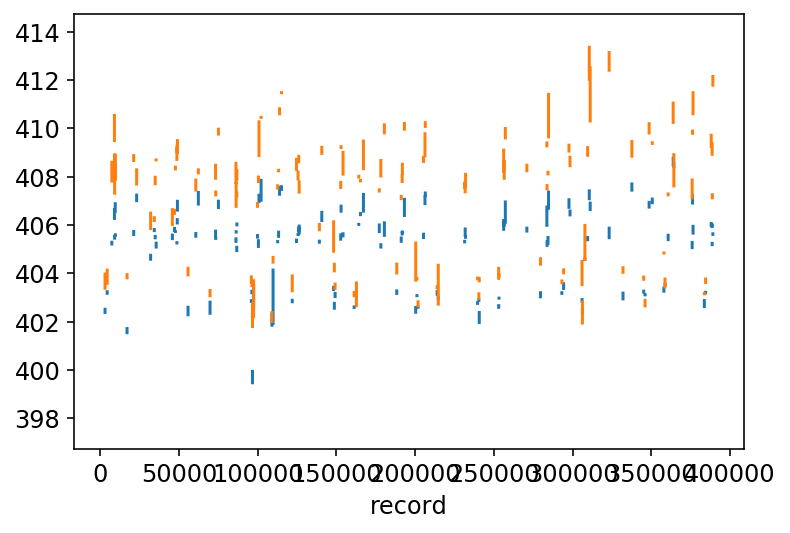

In [215]:
# calculate y_obs - H(x_f)
# model simulated CO2 concentration
co2_model = ds_model['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppm
# 
co2_profile = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model
# sum up to get column CO2
xco2_model = co2_profile.sum(dim = 'levels')      # sum along vertical axis, unit: ppbv to ppm

if mode == 'N':
    xco2_model_mode = xco2_model * mode_mask # extract desired mode of observation: Nadir
else:
    xco2_model_mode = xco2_model
xco2_model_mode[xco2_model_mode==0] = 'nan'

if mode == 'N':
    xco2_oco2_mode = ds_satellite['xco2'] * mode_mask
else:
    xco2_oco2_mode = ds_satellite['xco2']
xco2_oco2_mode[xco2_oco2_mode==0] = 'nan'

xco2_model_mode.plot()
xco2_oco2_mode.plot()

In [216]:
obs_series = xco2_oco2_mode.values
model_series = xco2_model_mode.values
R = ma.corrcoef(ma.masked_invalid(obs_series), ma.masked_invalid(model_series))

x = obs_series[~np.isnan(obs_series)]
y = model_series[~np.isnan(model_series)]
rmse = np.sqrt(((y - x) ** 2).mean())

format_R = float("{0:.2f}".format(R[0,1]))
format_rmse = float("{0:.2f}".format(rmse))
print('R is:', format_R, ' RMSE is: ', format_rmse)

R is: 0.89  RMSE is:  2.51


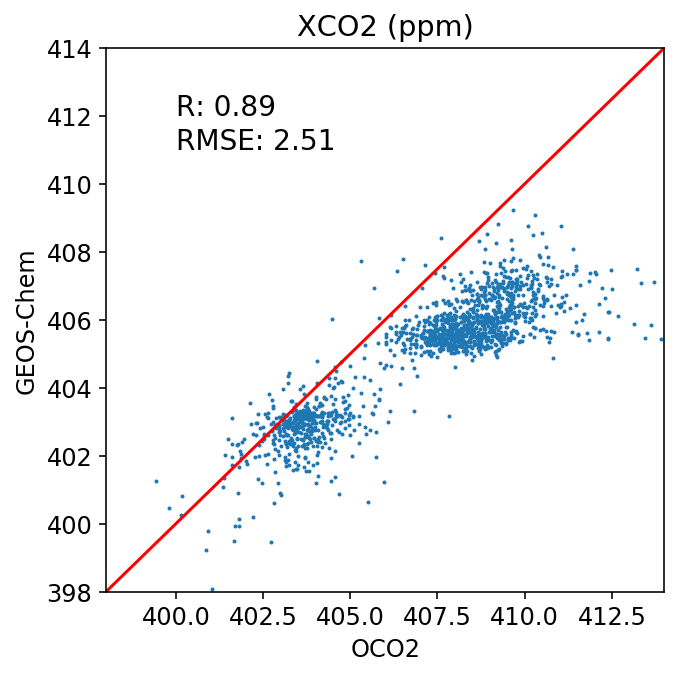

In [217]:
fig = plt.figure(figsize=[5,5])

plt.scatter(xco2_oco2_mode, xco2_model_mode, s=1)
plt.plot([300,450],[300,450], c='r')
plt.ylim(top   = 414,bottom = 398)
plt.xlim(right = 414,left   = 398)
plt.title('XCO2 (ppm)')
plt.ylabel('GEOS-Chem')
plt.xlabel('OCO2')
plt.text(x=400, y=412, s='R: ' + str(format_R), size = 14)
plt.text(x=400, y=411, s='RMSE: ' + str(format_rmse), size = 14)

fig.savefig(output_directory + '/mod_vs_obs_XCO2_' + mode + '_'+ name_month + '.png', dpi=300)

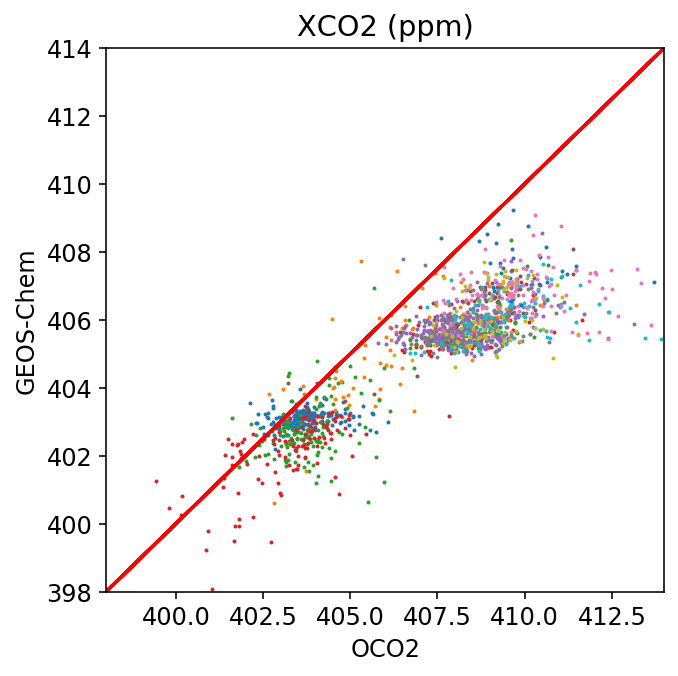

In [218]:
# apply different masks
fig = plt.figure(figsize=[5,5])

for iregion in range(1,22):
    maskname = 'MASK' + str(iregion)
    xco2_model_mask = xco2_model_mode * ds_mask[maskname][0:len(xco2_model)]
    xco2_model_mask[xco2_model_mask==0] = 'nan'
    xco2_oco2_mask = xco2_oco2_mode * ds_mask[maskname][0:len(xco2_model)]
    xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'
    
    plt.scatter(xco2_oco2_mask, xco2_model_mask, s=1)
    plt.plot([300,450],[300,450], c='r')
    plt.ylim(top   = 414,bottom = 398)
    plt.xlim(right = 414,left   = 398)
    plt.title('XCO2 (ppm)')
    plt.ylabel('GEOS-Chem')
    plt.xlabel('OCO2')

Text(0.5, 0, 'OCO2')

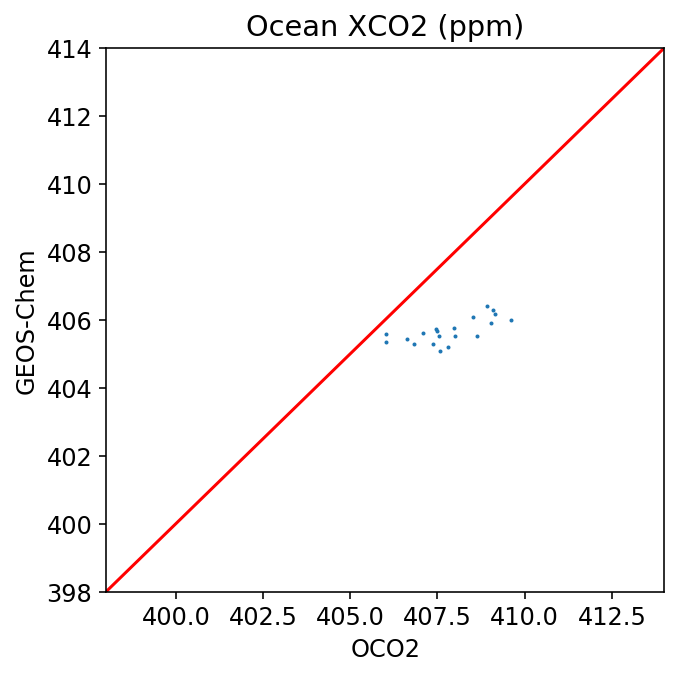

In [219]:
# last mask, ocean and artics
xco2_model_mask = xco2_model_mode * ds_mask['MASK22'][0:len(xco2_model)]
xco2_model_mask[xco2_model_mask==0] = 'nan'
xco2_oco2_mask = xco2_oco2_mode * ds_mask['MASK22'][0:len(xco2_model)]
xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'
    
fig = plt.figure(figsize=[5,5])

plt.scatter(xco2_oco2_mask, xco2_model_mask, s=1)
plt.plot([300,450],[300,450], c='r')
plt.ylim(top   = 414,bottom = 398)
plt.xlim(right = 414,left   = 398)
plt.title('Ocean XCO2 (ppm)')
plt.ylabel('GEOS-Chem')
plt.xlabel('OCO2')

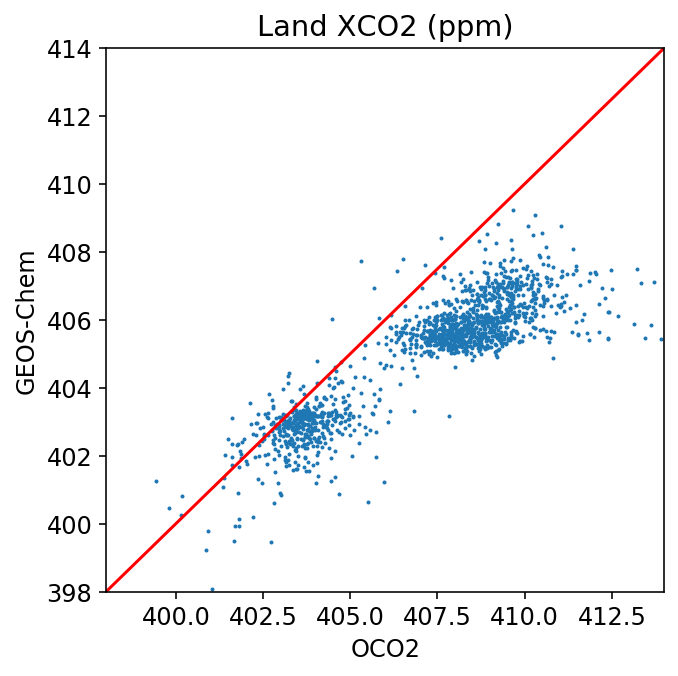

In [220]:
# land only
xco2_model_land = xco2_model_mode * ds_mask['land'][0:len(xco2_model)]
xco2_model_land[xco2_model_land==0] = 'nan'
xco2_oco2_land = xco2_oco2_mode * ds_mask['land'][0:len(xco2_model)]
xco2_oco2_land[xco2_oco2_land==0] = 'nan'
    
fig = plt.figure(figsize=[5,5])

plt.scatter(xco2_oco2_land, xco2_model_land, s=1)
plt.plot([300,450],[300,450], c='r')
plt.ylim(top   = 414,bottom = 398)
plt.xlim(right = 414,left   = 398)
plt.title('Land XCO2 (ppm)')
plt.ylabel('GEOS-Chem')
plt.xlabel('OCO2')

fig.savefig(output_directory + '/mod_vs_obs_XCO2_land_' + mode + '_' + name_month + '.png', dpi=300)

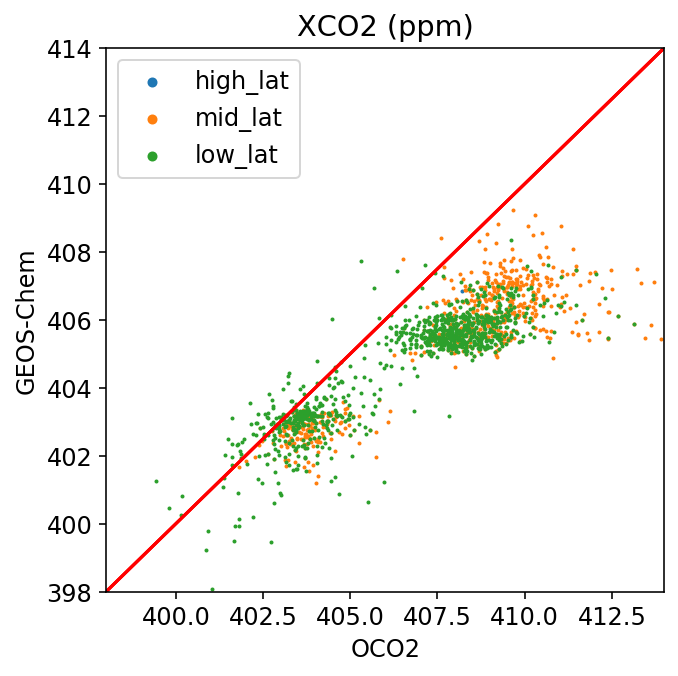

In [221]:
# look at different latitude bands
fig = plt.figure(figsize=[5,5])

for region in ['high_lat', 'mid_lat', 'low_lat']:
    xco2_model_mask = xco2_model_land * ds_mask[region][0:len(xco2_model_land)]
    xco2_model_mask[xco2_model_mask==0] = 'nan'
    xco2_oco2_mask = xco2_oco2_land * ds_mask[region][0:len(xco2_model_land)]
    xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'
    
    plt.scatter(xco2_oco2_mask, xco2_model_mask, s=1, label = region)
    plt.plot([300,450],[300,450], c='r')
    plt.ylim(top   = 414,bottom = 398)
    plt.xlim(right = 414,left   = 398)
    plt.title('XCO2 (ppm)')
    plt.ylabel('GEOS-Chem')
    plt.xlabel('OCO2')
    plt.legend(markerscale = 4)
    
    fig.savefig(output_directory + '/mod_vs_obs_XCO2_latitudinal_'+ mode + '_' + name_month + '.png', dpi=300)

In [222]:
diff = xco2_oco2_land - xco2_model_land   # diff to calculate a posteriori
new_data = diff.to_dataset(name = 'diff')
new_data['xco2_oco2'] = xco2_oco2_land
new_data['xco2_model'] = xco2_model_land
new_data['xco2_error'] = ds_satellite['xco2_uncertainty']
new_data['lat'] = ds_model['lat']
new_data['lon'] = ds_model['lon']
new_data['date'] = ds_model['date']
new_data.to_netcdf(output_directory + 'XCO2_mod_and_oco2_' + mode + '_' + name_month + '.nc')

In [223]:
# 2d maps of differences

In [224]:
diff2 = xco2_model_land - xco2_oco2_land # diff to map onto global map
# Creat target dataarray and dataset
lat_res = 2    # horizontal resolution of lat and lon you would want
lon_res = 2.5
lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
lon = np.linspace(-180, 177.5, int(360/lon_res))
days = len(diff)/(len(lat)*len(lon))

var_3d = xr.DataArray(data = np.nan, 
                      dims = ('days', 'lat', 'lon'), 
                      coords = {'days': range(int(days)),
                                'lat': lat,
                                'lon': lon},
                      name = '')
var_3d = var_3d.astype(dtype='float32')
var_3d.shape

(31, 91, 144)

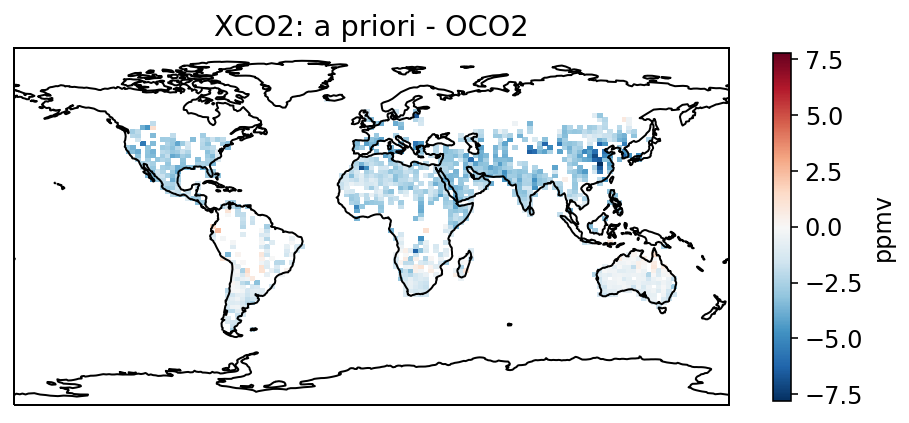

In [225]:
var_3d.values = diff2.values.reshape((int(days),len(lat),len(lon)))
var_2d = var_3d.mean(dim='days')
# plot after mapping
fig = plt.figure(figsize=[8, 8])
proj=ccrs.PlateCarree()

ax = plt.subplot(111, projection=proj)
ax.coastlines()
var_2d.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.4, 'label': 'ppmv'})
ax.set_title('XCO2: a priori - OCO2');

fig.savefig(output_directory + '/diff_map_' + name_month + '.png', dpi=300)